In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid # Для интегрирования методом трапеций
from scipy.fft import fft, fftfreq
from scipy.signal import get_window  # Добавляем оконную функцию

In [2]:
file_path = "file957.txt"  # Путь к файлу
# Определение кодировки текста в txt файле
import chardet

with open(file_path, "rb") as f:
    raw_data = f.read(10000)  # Читаем кусок файла. Если не указать число, то читается весь файл
    result = chardet.detect(raw_data)  # Определяем кодировку
    print(result)

{'encoding': 'windows-1251', 'confidence': 0.935441697818452, 'language': 'Russian'}


In [3]:
file_path = 'file957.txt'  # Путь к файлу

# Чтение заголовков (22-я строка, индекс 22)
with open(file_path, 'r', encoding="cp1251") as file:
    lines = file.readlines() # Строку с заголовками можно проверить print(lines[21])

column_names = lines[21].strip().split('\t')  # Список заголовков с разделением по табуляция (из файла)

pd.set_option('display.float_format', '{:0.12f}'.format) #12 знаков после запятой

# Чтение данных в pandas DataFrame, пропуская первую часть файла с метаинформацией (21 строка)
data = pd.read_csv(file_path, skiprows=22, sep="\t", decimal=",",names=column_names, encoding="cp1251")
data = data.drop(columns=['Comment']) # Удаление столбца с комментариями

print(data.head())

   X_Value        Time, s  X1 position, mm  Y1 position, mm  X2 position, mm  \
0      NaN 0.000000000000   0.000000000000 -10.000000000000   0.000000000000   
1      NaN 0.088002000000   0.000000000000 -10.000000000000   0.000000000000   
2      NaN 0.175003000000   0.000000000000 -10.000000000000   0.000000000000   
3      NaN 0.264004000000   0.000000000000 -10.000000000000   0.000000000000   
4      NaN 0.376006000000   0.000000000000 -10.000000000000   0.000000000000   

   Y2 position, mm   Signal, Volt  
0 -10.000000000000 0.000002494450  
1 -10.000000000000 0.000002272167  
2 -10.000000000000 0.000002314732  
3 -10.000000000000 0.000002286356  
4 -10.000000000000 0.000002376215  


Характеристики эксперимента

In [4]:
L = 3 # Длина натянутой нити, м
V = 1 # Скорость поступательного движения нити, мм/с

Перевод данных в формат для вычислений

In [5]:
# Преобразуем координаты и время в нужный формат, если необходимо ||| (например, удалить лишние пробелы или символы)???
data['Time, s'] = data['Time, s'].astype(float)
data['X1 position, mm'] = data['X1 position, mm'].astype(float)
data['Y1 position, mm'] = data['Y1 position, mm'].astype(float)
data['X2 position, mm'] = data['X2 position, mm'].astype(float)
data['Y2 position, mm'] = data['Y2 position, mm'].astype(float)
data['Signal, Volt'] = data['Signal, Volt'].astype(float)

Расчёт значений первого интеграла магнитного поля

In [6]:
data['Velocity'] = (data['X2 position, mm'] - data['X1 position, mm']) / (data['Time, s'].diff()) # Скорость нити

data['EDS'] = - data['Signal, Volt'] # ЭДС

data['Magnetic_Field_Integral'] = data['EDS'] / data['Velocity'] # Значения первого магнитного интеграла

# Обработка нулевой скорости
data['Magnetic_Field_Integral'] = np.where(data['Velocity'] != 0, data['EDS'] / data['Velocity'], np.nan)

# Удаление строк с NaN (можно заменить на другие значения, если нужно)
data = data.dropna(subset=['Magnetic_Field_Integral'])


print(data['Magnetic_Field_Integral'])

24    0.000208764867
25    0.000167972544
26    0.000189517784
27    0.000139565271
28    0.000259426973
           ...      
230   0.000164242602
231   0.000104279929
232   0.000202257154
233   0.000043535751
234   0.000018155909
Name: Magnetic_Field_Integral, Length: 209, dtype: float64


In [7]:
# Сглаживание с помощью скользящего среднего
window_size = 7  # Размер окна
smoothed_data = data['Magnetic_Field_Integral'].rolling(window=window_size).mean()

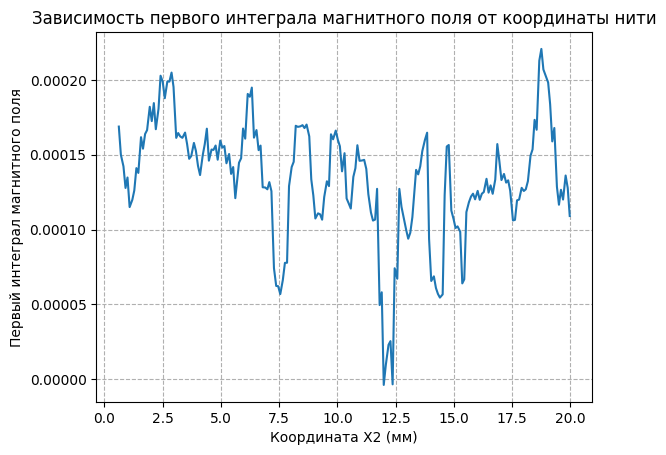

In [8]:
# Строим график зависимости первого магнитного поля от координаты нити (X1, например)
#plt.plot(data['X2 position, mm'], data['Magnetic_Field_Integral'])
plt.plot(data['X2 position, mm'], smoothed_data)
plt.xlabel('Координата X2 (мм)')
plt.ylabel('Первый интеграл магнитного поля')
plt.title('Зависимость первого интеграла магнитного поля от координаты нити')
plt.grid(which="both", linestyle="--")  # Сетка для удобства
plt.show()

In [9]:
# Метод межквартильного размаха (IQR)
Q1 = data['Magnetic_Field_Integral'].quantile(0.25)
Q3 = data['Magnetic_Field_Integral'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов (с сохранением правильных индексов)
data_filtered = data[(data['Magnetic_Field_Integral'] >= lower_bound) & 
                     (data['Magnetic_Field_Integral'] <= upper_bound)]

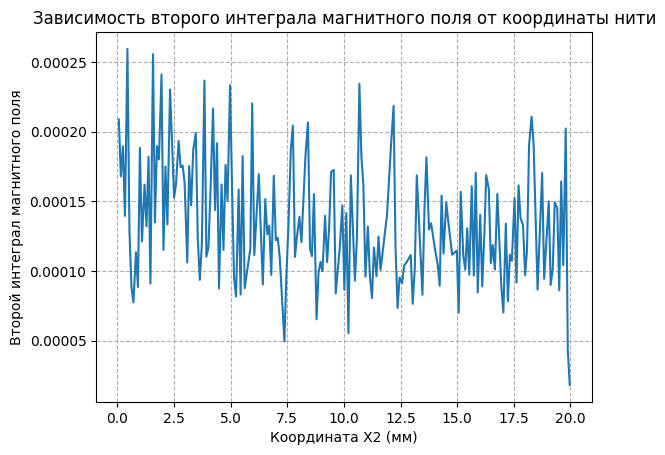

In [10]:
# Строим график зависимости второго магнитного поля от координаты нити (X1, например)
#plt.plot(data['X2 position, mm'], data['Magnetic_Field_Integral'])
plt.plot(data_filtered['X2 position, mm'], data_filtered['Magnetic_Field_Integral'])
plt.xlabel('Координата X2 (мм)')
plt.ylabel('Второй интеграл магнитного поля')
plt.title('Зависимость второго интеграла магнитного поля от координаты нити')
plt.grid(which="both", linestyle="--")  # Сетка для удобства
plt.show()

In [11]:
file_path = 'output_file.txt'  # Путь к файлу, куда хотите сохранить

# Записываем данные в текстовый файл с разделением по табуляции
#data.to_csv(file_path, index=False, sep='\t', encoding='cp1251')
#data.to_csv('output_file.csv', index=False, sep=',', encoding='cp1251')
data.to_excel('output_file.xlsx', index=False)

ModuleNotFoundError: No module named 'openpyxl'

Оригинальный график

In [ ]:
# Строим график зависимости второго магнитного поля от координаты нити (X1, например)
plt.plot(data['X2 position, mm'], data['Magnetic_Field_Integral'])
plt.xlabel('Координата X2 (мм)')
plt.ylabel('Второй интеграл магнитного поля')
plt.title('Зависимость второго интеграла магнитного поля от координаты нити')
plt.grid(which="both", linestyle="--")  # Сетка для удобства
plt.show()

Для движения по окружности

In [ ]:
file_path_rad = 'file2116.txt'  # Путь к файлу

# Чтение заголовков (22-я строка, индекс 22)
with open(file_path_rad, 'r', encoding="cp1251") as file:
    lines_rad = file.readlines() # Строку с заголовками можно проверить print(lines[21])

column_names_rad = lines_rad[21].strip().split('\t')  # Список заголовков с разделением по табуляция (из файла)

pd.set_option('display.float_format', '{:0.12f}'.format) #12 знаков после запятой

# Чтение данных в pandas DataFrame, пропуская первую часть файла с метаинформацией (21 строка)
data_rad = pd.read_csv(file_path_rad, skiprows=22, sep="\t", decimal=",",names=column_names_rad, encoding="cp1251")
data_rad = data_rad.drop(columns=['Comment']) # Удаление столбца с комментариями

#print(data_rad.head())

In [ ]:
time_rad = data_rad['Time, s'].values
x1_rad = data_rad['X1 position, mm'].values
y1_rad = data_rad['Y1 position, mm'].values
x2_rad = data_rad['X2 position, mm'].values
y2_rad = data_rad['Y2 position, mm'].values
eds_rad = data_rad['Signal, Volt'].values

In [ ]:
# Убираем DC-компоненту (вычитаем среднее значение)
#eds_rad -= np.mean(eds_rad)

# Выполняем преобразование Фурье
N = len(time_rad)
fft_values = fft(eds_rad)
freqs = np.fft.fftfreq(N, d=(time_rad[1] - time_rad[0])) * 2 * np.pi  # Преобразуем в круговую частоту

# Вычисление амплитуд гармоник
amplitudes = (2.0 / N )* np.abs(fft_values[:N // 2])

# Вывод коэффициентов мультипольного разложения
for i, amp in enumerate(amplitudes[:10]):
    print(f"Гармоника {i}: амплитуда = {amp:.3e}")  # Форматируем с одной цифрой после запятой

# Находим индекс максимальной амплитуды
main_harmonic_index = np.argmax(amplitudes)

# Получаем частоту основной гармоники
main_harmonic_freq = freqs[main_harmonic_index]

# Выводим результат
print(f"Основная гармоника: частота = {main_harmonic_freq:.3e} рад/с, амплитуда = {amplitudes[main_harmonic_index]:.3e}")




Гармоника 0: амплитуда = 9.968e-07
Гармоника 1: амплитуда = 1.240e-06
Гармоника 2: амплитуда = 1.425e-05
Гармоника 3: амплитуда = 1.722e-06
Гармоника 4: амплитуда = 1.241e-06
Гармоника 5: амплитуда = 1.210e-06
Гармоника 6: амплитуда = 1.093e-06
Гармоника 7: амплитуда = 9.412e-07
Гармоника 8: амплитуда = 8.105e-07
Гармоника 9: амплитуда = 7.783e-07
Основная гармоника: частота = 1.151e-01 рад/с, амплитуда = 1.425e-05


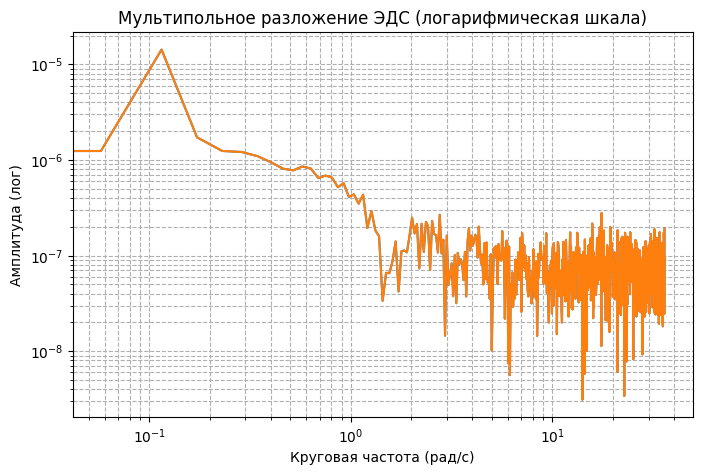

In [ ]:
# График разложения с логарифмической шкалой по обеим осям
plt.figure(figsize=(8, 5))  # Создаем фигуру для графика
plt.semilogx(freqs[:N // 2], amplitudes, '-')  # Логарифмический масштаб по X
plt.semilogy(freqs[:N // 2], amplitudes, '-')  # Логарифмический масштаб по Y
plt.xlabel("Круговая частота (рад/с)")  # Подпись оси X
plt.ylabel("Амплитуда (лог)")  # Подпись оси Y
plt.title("Мультипольное разложение ЭДС (логарифмическая шкала)")  # Заголовок графика
plt.grid(which="both", linestyle="--")  # Сетка для удобства
plt.show()  # Отображаем график

In [ ]:
# Убираем DC-компоненту (вычитаем среднее значение)
eds_rad -= np.mean(eds_rad)

# Применяем оконную функцию Ханна
window = get_window("hann", len(eds_rad))  # Создаем окно Ханна
eds_rad *= window  # Применяем окно к сигналу

# Выполняем преобразование Фурье
N = len(time_rad)  # Количество точек во временном ряду
fft_values = fft(eds_rad)  # Преобразование Фурье для ЭДС
freqs = np.fft.fftfreq(N, d=(time_rad[1] - time_rad[0])) * 2 * np.pi  # Преобразуем в круговую частоту

# Вычисление амплитуд гармоник
amplitudes = 2.0 / N * np.abs(fft_values[:N // 2])  # Вычисление модуля спектра

# Отбрасываем слишком малые амплитуды (шум)
threshold = 1e-10  # Порог отсечения
amplitudes[amplitudes < threshold] = np.nan  # Меняем малые значения на NaN, чтобы они не отображались

# Вывод коэффициентов мультипольного разложения
for i, amp in enumerate(amplitudes[:10]):  # Перебираем первые 10 гармоник
    print(f"Гармоника {i}: амплитуда = {amp:.3e}")  # Форматируем с одной цифрой после запятой



Гармоника 0: амплитуда = 6.031e-07
Гармоника 1: амплитуда = 4.164e-06
Гармоника 2: амплитуда = 7.850e-06
Гармоника 3: амплитуда = 4.107e-06
Гармоника 4: амплитуда = 1.166e-07
Гармоника 5: амплитуда = 2.209e-08
Гармоника 6: амплитуда = 4.973e-08
Гармоника 7: амплитуда = 1.007e-07
Гармоника 8: амплитуда = 1.030e-07
Гармоника 9: амплитуда = 5.241e-08


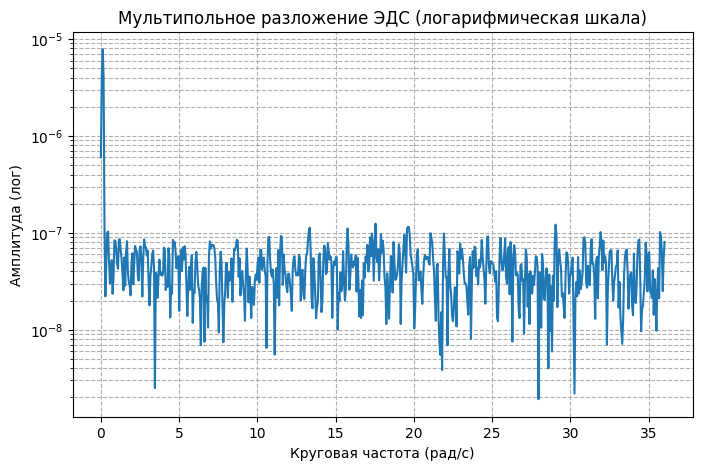

In [ ]:
# График разложения с логарифмической шкалой
plt.figure(figsize=(8, 5))  # Создаем фигуру для графика
plt.semilogy(freqs[:N // 2], amplitudes, '-')  # Логарифмический масштаб по Y без точек
plt.xlabel("Круговая частота (рад/с)")  # Подпись оси X
plt.ylabel("Амплитуда (лог)")  # Подпись оси Y
plt.title("Мультипольное разложение ЭДС (логарифмическая шкала)")  # Заголовок графика
plt.grid(which="both", linestyle="--")  # Сетка для удобства
plt.show()  # Отображаем график